In [40]:
import torch
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
import numpy as np
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils import data
from torchvision.datasets import ImageFolder
from torchvision import transforms
import multiprocessing
from functools import partial
import math


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model(ckpt=None):
    config = OmegaConf.load("models/ldm/att_ffhq/config_v4.yaml")
    if ckpt:
        model = load_model_from_config(config, ckpt)
    else:
        model = instantiate_from_config(config.model)
    return model


class expand_greyscale(object):
    def __init__(self, transparent):
        self.transparent = transparent

    def __call__(self, tensor):
        channels = tensor.shape[0]
        num_target_channels = 4 if self.transparent else 3

        if channels == num_target_channels:
            return tensor

        alpha = None
        if channels == 1:
            color = tensor.expand(3, -1, -1)
        elif channels == 2:
            color = tensor[:1].expand(3, -1, -1)
            alpha = tensor[1:]
        else:
            raise Exception(f'image with invalid number of channels given {channels}')

        if not exists(alpha) and self.transparent:
            alpha = torch.ones(1, *tensor.shape[1:], device=tensor.device)

        return color if not self.transparent else torch.cat((color, alpha))


class Dataset(data.Dataset):
    def __init__(self, folder, image_size, transparent=False, aug_prob=0.):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for ext in EXTS for p in Path(f'{folder}').glob(f'**/*.{ext}')]
        assert len(self.paths) > 0, f'No images were found in {folder} for training'

        convert_image_fn = convert_transparent_to_rgb if not transparent else convert_rgb_to_transparent
        num_channels = 3 if not transparent else 4

        self.transform = transforms.Compose([
            transforms.Lambda(convert_image_fn),
            transforms.Lambda(partial(resize_to_minimum_size, image_size)),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Lambda(expand_greyscale(transparent))
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)

def exists(val):
    return val is not None    
    
def default(value, d):
    return value if exists(value) else d

def cycle(iterable):
    while True:
        for i in iterable:
            yield i


In [41]:
from pathlib import Path
NUM_CORES = multiprocessing.cpu_count()
EXTS = ['jpg', 'jpeg', 'png']

def convert_transparent_to_rgb(image):
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

def resize_to_minimum_size(min_size, image):
    if max(*image.size) < min_size:
        return torchvision.transforms.functional.resize(image, min_size)
    return image

def set_data_src(folder='./', dataset_name=None, image_size=64, batch_size=1, num_workers=4, is_ddp=False, rank=0, world_size=1):
    if dataset_name is None:
        dataset = Dataset(folder, image_size)
        num_workers = default(num_workers, NUM_CORES if not is_ddp else 0)

        dataloader = DataLoader(dataset, num_workers=num_workers,
                                     batch_size=math.ceil(batch_size / world_size),
                                     shuffle=False, drop_last=True, pin_memory=True)
    else:
        raise NotImplementedError("This dataset is not supported yet. Please use dataset_name = None.")

    loader = cycle(dataloader)
    return dataset, loader

In [5]:
model = get_model("./last.ckpt")
model = model.to("cuda")
sampler = DDIMSampler(model)

Loading model from ./last.ckpt
LatentDiffusion: Running in eps-prediction mode


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DiffusionWrapper has 400.92 M params.


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/aim/storage/structured/sql_engine/models.py:16: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [42]:
n_samples = 8
ddim_steps = 20
ddim_eta = 0.0
scale = 3.0  # for unconditional guidance
data_path = "/root/Explaining-In-Style-Reproducibility-Study/data/Kaggle_FFHQ_Resized_256px/flickrfaceshq-dataset-nvidia-resized-256px/resized"

all_samples = list()
dataset, dataloader = set_data_src(folder=data_path, dataset_name=None, image_size=64, batch_size=n_samples)


In [47]:
y = next(data_iter)
print(y.shape)

torch.Size([8, 3, 64, 64])


Data shape for DDIM sampling is (8, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Data shape for DDIM sampling is (8, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Data shape for DDIM sampling is (8, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


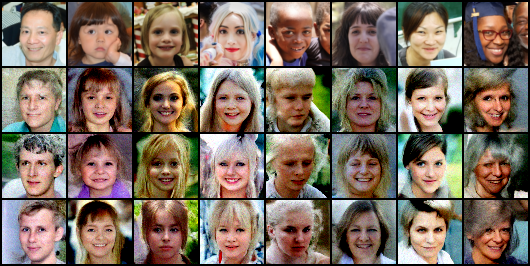

In [73]:
data_iter = iter(dataloader)
test_dim = 251  # a dim between [0-511]
sign = -1 # [1, -1]
# TODO: try with unconditional_guidance_scale
# TODO: ???batch size of cond and batch size of sample
with torch.no_grad():
    batch = next(data_iter).cuda()
    with model.ema_scope():
#         uc = model.get_learned_conditioning(
#             {"class_label": self.classifier.classify_images(batch),
#              "image_batch": batch}
#         )
        c = model.get_learned_conditioning(
            {"class_label": model.classifier.classify_images(batch),
             "image_batch": batch}
        )
        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                         conditioning=c,
                                         batch_size=8,
                                         shape=[3, 64, 64],
                                         verbose=False,
                                         eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
#         x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
#                                      min=0.0, max=1.0)
        x_samples_ddim = torch.clamp(x_samples_ddim, min=0.0, max=1.0)
    
        dirs = torch.Tensor([0.0002]*8).cuda() * sign
        c[:, 0, test_dim] += dirs
        samples_ddim2, _ = sampler.sample(S=ddim_steps,
                                         conditioning=c,
                                         batch_size=8,
                                         shape=[3, 64, 64],
                                         verbose=False,
                                         eta=ddim_eta)
        x_samples_ddim2 = model.decode_first_stage(samples_ddim2)
        x_samples_ddim2 = torch.clamp(x_samples_ddim2, min=0.0, max=1.0)
        
        c[:, 0, test_dim] += dirs
        samples_ddim3, _ = sampler.sample(S=ddim_steps,
                                         conditioning=c,
                                         batch_size=8,
                                         shape=[3, 64, 64],
                                         verbose=False,
                                         eta=ddim_eta)
        x_samples_ddim3 = model.decode_first_stage(samples_ddim3)
        x_samples_ddim3 = torch.clamp(x_samples_ddim3, min=0.0, max=1.0)
        
        
grid = torch.stack([batch, x_samples_ddim, x_samples_ddim2, x_samples_ddim3], 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=8)
        
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))      

In [55]:
c.shape

torch.Size([8, 1, 512])

In [59]:
torch.mean(c)

tensor(0.0027, device='cuda:0')